In [1]:
from data_aug.data_aug import *
from data_aug.bbox_util import *
import numpy as np 
import pandas as pd
import cv2 
import matplotlib.pyplot as plt 
import pickle as pkl
%matplotlib inline

In [2]:
def get_annot(annot_path = 'dataset/LEs920/ann.txt'):
    """get annotation from dataset text"""
    with open(annot_path, 'r') as f:
        txt = f.readlines()
        annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]
    resdic = {}
    for ann in annotations:
        ann = ann.split(' ')
        image_path = ann[0]
        boxarr = []
        for a in ann[1:]:
            box = np.fromstring(a, sep=',')
            boxarr.append(box)
        boxarr = np.array(boxarr)
        resdic[image_path] = boxarr

    return resdic



In [3]:
def random_colors(N, bright=True):
    '''
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    '''
    import random
    import colorsys

    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def plot_bboxes(img, bboxes, labels=[], ax=None, figsize=(8, 8), title=None):
    """
    Draw bounding boxes on image
    img: img array
    bboxes: bounding boxes array, shape [N bboxes, 4]
    """
    import random
    import matplotlib.pyplot as plt
    from matplotlib import patches
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
    
    N = bboxes.shape[0]
    colors = random_colors(N)
    ax.imshow(img)
    ax.set_title(title)
    for i in range(N):
        # for faster rcnn
        #y1, x1, y2, x2 = bboxes[i] [:4]
        #y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)

        # for yolo
        x1, y1, x2, y2 = bboxes[i][:4]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=colors[i], facecolor='none')
        ax.add_patch(p)
        
        # Label
        #class_id = class_ids[i]
        #score = scores[i] if scores is not None else None
        #label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        
        if len(labels)!=0:
            caption = "{:.1f}".format( labels[i] )
        else:
            caption = None
        ax.text(x2 - 8, y1, caption,
                color='w', size=10, backgroundcolor="none")




In [4]:
def fits_to_uint8(fitsarr, vmin=-1, vmax=1,):
    
    # clip
    data = np.clip(fitsarr, vmin, vmax)
    # scale to [0,1]
    data = (data - vmin) / (vmax - vmin)
    # convert to uint8
    data = (255 * data).astype(np.uint8)
    # invert y axis
    #data = data[::-1, :]
    return data



### load dataset 

In [5]:
pwd

'/Users/home/Documents/Research/preprocessing'

In [6]:
ls

LE576_aug_train_test_split.ipynb  data_aug/
LEs576_star/                      dataset/
LEs576_star_coco/                 fits_crop_split_skymap.ipynb
SNR.ipynb                         labelme2coco.py
__pycache__/                      labelme2voc.py
albumentations.ipynb              labels.txt
ann.pdf                           labels2.txt
ann_largebox.pdf                  normalize.ipynb
atlas/                            prepare_dataset_yolov5.ipynb
cand1.csv                         texput.log
coco_mask.ipynb                   utils.py
coco_to_yolo.ipynb                viewbox.ipynb
cross_validation.ipynb


In [7]:
# path to annotation file before augmentation

anndic = get_annot(annot_path='./dataset/LE_cand1_cls3/LE_all.txt')
imgfiles = list( anndic.keys() )

In [8]:
imgfiles

['./dataset/LE_cand1_cls3/tiles/005_8.jpg',
 './dataset/LE_cand1_cls3/tiles/009_8.jpg',
 './dataset/LE_cand1_cls3/tiles/003_2.jpg',
 './dataset/LE_cand1_cls3/tiles/010_6.jpg',
 './dataset/LE_cand1_cls3/tiles/014_1.jpg',
 './dataset/LE_cand1_cls3/tiles/018_1.jpg',
 './dataset/LE_cand1_cls3/tiles/001_2.jpg',
 './dataset/LE_cand1_cls3/tiles/014_0.jpg',
 './dataset/LE_cand1_cls3/tiles/003_4.jpg',
 './dataset/LE_cand1_cls3/tiles/006_7.jpg',
 './dataset/LE_cand1_cls3/tiles/013_5.jpg',
 './dataset/LE_cand1_cls3/tiles/017_3.jpg',
 './dataset/LE_cand1_cls3/tiles/006_6.jpg',
 './dataset/LE_cand1_cls3/tiles/002_1.jpg',
 './dataset/LE_cand1_cls3/tiles/017_0.jpg',
 './dataset/LE_cand1_cls3/tiles/004_4.jpg',
 './dataset/LE_cand1_cls3/tiles/006_5.jpg',
 './dataset/LE_cand1_cls3/tiles/002_2.jpg',
 './dataset/LE_cand1_cls3/tiles/011_6.jpg',
 './dataset/LE_cand1_cls3/tiles/007_0.jpg',
 './dataset/LE_cand1_cls3/tiles/006_4.jpg',
 './dataset/LE_cand1_cls3/tiles/015_0.jpg',
 './dataset/LE_cand1_cls3/tiles/

In [9]:
imgfile = imgfiles[0]
fitspath = imgfile.replace('jpg', 'fits.npz')
fitsarr = np.load(fitspath)['fitsarr']

bboxes_clsid = anndic[imgfile]
bboxes = bboxes_clsid[:, :4]
clsids = bboxes_clsid[:, 4] 

In [10]:
fitsarr.shape

(576, 576)

In [11]:
bboxes

array([[180., 403., 293., 425.],
       [266., 304., 340., 332.],
       [498., 106., 556., 187.],
       [272., 376., 366., 528.],
       [501., 327., 541., 367.],
       [315., 342., 348., 375.],
       [  1., 353., 110., 384.],
       [  0.,  61.,  47., 133.],
       [ 67., 553.,  91., 575.],
       [334., 544., 360., 570.],
       [368., 372., 461., 405.]])

In [12]:
clsids

array([0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.])

In [13]:
rgbimg = fits_to_uint8(fitsarr, vmax=1, vmin=-1)
plot_bboxes(img=rgbimg, bboxes=bboxes, labels=clsids)

In [14]:
hflip = HorizontalFlip()
vflip = VerticalFlip()
rotate90 = Rotate(angle=90)

In [15]:
def aug_rotate(fitsarr, bboxes):
    """rotate 90, 180, 270"""
    fitsarr_r90, bboxes_r90 = rotate90( img=fitsarr.copy(), bboxes=bboxes.copy() )
    fitsarr_r90 = np.rot90(fitsarr)
    
    fitsarr_r180, bboxes_r180 = rotate90( img=fitsarr_r90.copy(), bboxes=bboxes_r90.copy() )
    fitsarr_r180 = np.rot90(fitsarr_r90)
    
    fitsarr_r270, bboxes_r270 = rotate90( img=fitsarr_r180.copy(), bboxes=bboxes_r180.copy() )
    fitsarr_r270 = np.rot90(fitsarr_r180)
    
    return fitsarr_r90, fitsarr_r180, fitsarr_r270, bboxes_r90, bboxes_r180, bboxes_r270


In [16]:
fitsarr.shape

(576, 576)

In [17]:
len(fitsarr.shape)

2

In [18]:
np.repeat( np.expand_dims(fitsarr, axis=2), repeats=3, axis=2 ).shape

(576, 576, 3)

In [20]:

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs = axs.flatten()

tiledir = "./dataset/LE_cand1_cls3/tiles_aug" # directory to augmentated tiles
os.system(f"mkdir {tiledir}")

annaug_file = './dataset/LE_cand1_cls3/LE_all_aug.txt'
os.system(f"rm {annaug_file}")

for imgfile in imgfiles:
    #imgfile = imgfiles[0]
    fitspath = imgfile.replace('jpg', 'fits.npz')
    fitsarr = np.load(fitspath)['fitsarr']
    
    if len(fitsarr.shape)!=3:
        # expand dimensions
        fitsarr = np.repeat( np.expand_dims(fitsarr, axis=2), repeats=3, axis=2 )
    

    bboxes_clsid = anndic[imgfile]
    bboxes = bboxes_clsid[:, :4]
    clsids = bboxes_clsid[:, 4] 

    # flip 
    fitsarr_fliph, bboxes_fliph = hflip(img=fitsarr.copy(), bboxes=bboxes.copy() )
    #fitsarr_flipv, bboxes_flipv = vflip(img=fitsarr.copy(), bboxes=bboxes.copy() )

    #rotate
    fitsarr_r90, fitsarr_r180, fitsarr_r270, bboxes_r90, bboxes_r180, bboxes_r270 = aug_rotate(fitsarr, bboxes)
    fitsarr_fliph_r90, fitsarr_fliph_r180, fitsarr_fliph_r270, bboxes_fliph_r90, bboxes_fliph_r180, bboxes_fliph_r270 = aug_rotate(fitsarr_fliph, bboxes_fliph)
    #fitsarr_flipv_r90, fitsarr_flipv_r180, fitsarr_flipv_r270, bboxes_flipv_r90, bboxes_flipv_r180, bboxes_flipv_r270 = aug_rotate(fitsarr_flipv, bboxes_flipv)


    farrs = [fitsarr, fitsarr_r90, fitsarr_r180, fitsarr_r270, 
            fitsarr_fliph, fitsarr_fliph_r90, fitsarr_fliph_r180, fitsarr_fliph_r270, ]
            #fitsarr_flipv, fitsarr_flipv_r90, fitsarr_flipv_r180, fitsarr_flipv_r270]

    boxes = [bboxes, bboxes_r90, bboxes_r180, bboxes_r270, 
            bboxes_fliph, bboxes_fliph_r90, bboxes_fliph_r180, bboxes_fliph_r270, ]
            #bboxes_flipv, bboxes_flipv_r90, bboxes_flipv_r180, bboxes_flipv_r270, ]

    imgname = os.path.basename(imgfile).replace('.jpg', '')
    titles = [imgname + i for i in [ '', '_r90', '_r180', '_r270',
             '_fliph', '_fliph_r90', '_fliph_r180', '_fliph_r270',] ]
             #'_flipv', '_flipv_r90', '_flipv_r180', '_flipv_r270',

    with open(annaug_file, 'a') as f:
        for ax, farr, box, title in zip(axs, farrs, boxes, titles):
            rgbimg = fits_to_uint8(farr, vmin=-1, vmax=1)
            plot_bboxes(ax=ax, img=rgbimg, bboxes=box, title=title, labels=clsids)
            ax.set_axis_off()

            # save fits array to npz

            np.savez(file=f'{tiledir}/{title}.fits.npz', fitsarr=farr)

            # write to txt file

            image_ann = f'{tiledir}/{title}.jpg'
            print(image_ann)
            cv2.imwrite(image_ann, rgbimg)

            for i in range( len(box)):
                x1, y1, x2, y2 = box[i][:4]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                xmin = str(x1)
                ymin = str(y1)
                xmax = str(x2)
                ymax = str(y2)
                class_ind = str( int( clsids[i] ) )
                image_ann += ' ' + ','.join([xmin, ymin, xmax, ymax, class_ind])
            f.write(image_ann + "\n")

    # save figure 
    fig.savefig(f'{tiledir}/{imgname}.pdf', dpi=100)

    for ax in axs:
        ax.cla() # clear axis



90
90
90
90
90
90
./dataset/LE_cand1_cls3/tiles_aug/005_8.jpg
./dataset/LE_cand1_cls3/tiles_aug/005_8_r90.jpg
./dataset/LE_cand1_cls3/tiles_aug/005_8_r180.jpg
./dataset/LE_cand1_cls3/tiles_aug/005_8_r270.jpg
./dataset/LE_cand1_cls3/tiles_aug/005_8_fliph.jpg
./dataset/LE_cand1_cls3/tiles_aug/005_8_fliph_r90.jpg
./dataset/LE_cand1_cls3/tiles_aug/005_8_fliph_r180.jpg
./dataset/LE_cand1_cls3/tiles_aug/005_8_fliph_r270.jpg
90
90
90
90
90
90
./dataset/LE_cand1_cls3/tiles_aug/009_8.jpg
./dataset/LE_cand1_cls3/tiles_aug/009_8_r90.jpg
./dataset/LE_cand1_cls3/tiles_aug/009_8_r180.jpg
./dataset/LE_cand1_cls3/tiles_aug/009_8_r270.jpg
./dataset/LE_cand1_cls3/tiles_aug/009_8_fliph.jpg
./dataset/LE_cand1_cls3/tiles_aug/009_8_fliph_r90.jpg
./dataset/LE_cand1_cls3/tiles_aug/009_8_fliph_r180.jpg
./dataset/LE_cand1_cls3/tiles_aug/009_8_fliph_r270.jpg
90
90
90
90
90
90
./dataset/LE_cand1_cls3/tiles_aug/003_2.jpg
./dataset/LE_cand1_cls3/tiles_aug/003_2_r90.jpg
./dataset/LE_cand1_cls3/tiles_aug/003_2_r180.j

90
90
90
90
90
90
./dataset/LE_cand1_cls3/tiles_aug/006_4.jpg
./dataset/LE_cand1_cls3/tiles_aug/006_4_r90.jpg
./dataset/LE_cand1_cls3/tiles_aug/006_4_r180.jpg
./dataset/LE_cand1_cls3/tiles_aug/006_4_r270.jpg
./dataset/LE_cand1_cls3/tiles_aug/006_4_fliph.jpg
./dataset/LE_cand1_cls3/tiles_aug/006_4_fliph_r90.jpg
./dataset/LE_cand1_cls3/tiles_aug/006_4_fliph_r180.jpg
./dataset/LE_cand1_cls3/tiles_aug/006_4_fliph_r270.jpg
90
90
90
90
90
90
./dataset/LE_cand1_cls3/tiles_aug/015_0.jpg
./dataset/LE_cand1_cls3/tiles_aug/015_0_r90.jpg
./dataset/LE_cand1_cls3/tiles_aug/015_0_r180.jpg
./dataset/LE_cand1_cls3/tiles_aug/015_0_r270.jpg
./dataset/LE_cand1_cls3/tiles_aug/015_0_fliph.jpg
./dataset/LE_cand1_cls3/tiles_aug/015_0_fliph_r90.jpg
./dataset/LE_cand1_cls3/tiles_aug/015_0_fliph_r180.jpg
./dataset/LE_cand1_cls3/tiles_aug/015_0_fliph_r270.jpg
90
90
90
90
90
90
./dataset/LE_cand1_cls3/tiles_aug/008_5.jpg
./dataset/LE_cand1_cls3/tiles_aug/008_5_r90.jpg
./dataset/LE_cand1_cls3/tiles_aug/008_5_r180.j

In [21]:
def switchxy(boxes):
    """switch the coord of bounding boxes
    bboxes: array, shape [N, 4]
    """
    boxes_new = np.zeros( boxes.shape )
    boxes_new[:, 0],  boxes_new[:, 1]= boxes[:, 1], boxes[:, 0]
    boxes_new[:, 2],  boxes_new[:, 3]= boxes[:, 3], boxes[:, 2]

    return boxes_new.astype(np.float32)

### check augmentated dataset

In [21]:
anndic = get_annot(annot_path='./dataset/LE_cand1_cls3/LE_all_aug.txt')
imgfiles = list( anndic.keys() )
len(imgfiles)

240

In [22]:
imgfile = imgfiles[30]
fitspath = imgfile.replace('jpg', 'fits.npz')
fitsarr = np.load(fitspath)['fitsarr']

bboxes_clsid = anndic[imgfile]

bboxes = bboxes_clsid[:, :4]
clsids = bboxes_clsid[:, 4] 

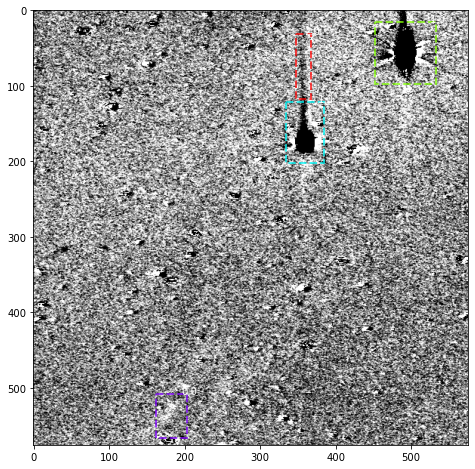

In [23]:
rgbimg = fits_to_uint8(fitsarr)
plot_bboxes(img=rgbimg, bboxes=bboxes, labels=clsids)

### split train / test regardless of fields

In [50]:
np.random.seed(seed=0)
idxs = np.random.permutation( len(imgfiles) )

spl = int( 0.7 * len(imgfiles) )

idx_train = idxs[:spl]
idx_test = idxs[spl:]

len(idx_train), len(idx_test), len(imgfiles)

(251, 109, 360)

In [134]:
# split train, test
with open("./dataset/LEs576aug/train_aug.txt", 'w') as f:

    for image_idx in idx_train:
        
        imgfile = imgfiles[image_idx]
        bboxes = resdic[ imgfile ]
        image_ann = imgfile
        print('trainset', image_ann)
        #cv2.imwrite(image_ann, rgb_img)
        for i in range( len(bboxes)):
            x1, y1, x2, y2 = bboxes[i][:4]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            xmin = str(x1)
            ymin = str(y1)
            xmax = str(x2)
            ymax = str(y2)
            class_ind = str( int( bboxes[i][4] ) )
            image_ann += ' ' + ','.join([xmin, ymin, xmax, ymax, class_ind])
        f.write(image_ann + "\n")

with open("./dataset/LEs576aug/test_aug.txt", 'w') as f:

    for image_idx in idx_test:
        
        imgfile = imgfiles[image_idx]
        bboxes = resdic[ imgfile ]
        image_ann = imgfile
        print('testset', image_ann)
        #cv2.imwrite(image_ann, rgb_img)
        for i in range( len(bboxes)):
            x1, y1, x2, y2 = bboxes[i][:4]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            xmin = str(x1)
            ymin = str(y1)
            xmax = str(x2)
            ymax = str(y2)
            class_ind = str( int( bboxes[i][4] ) )
            image_ann += ' ' + ','.join([xmin, ymin, xmax, ymax, class_ind])
        f.write(image_ann + "\n")


trainset ./dataset/LEs576aug/tiles_aug/002_0_fliph_r90.jpg
trainset ./dataset/LEs576aug/tiles_aug/003_7_flipv_r90.jpg
trainset ./dataset/LEs576aug/tiles_aug/005_0_flipv.jpg
trainset ./dataset/LEs576aug/tiles_aug/014_5_flipv.jpg
trainset ./dataset/LEs576aug/tiles_aug/013_8.jpg
trainset ./dataset/LEs576aug/tiles_aug/007_0_flipv_r270.jpg
trainset ./dataset/LEs576aug/tiles_aug/002_1_r90.jpg
trainset ./dataset/LEs576aug/tiles_aug/013_8_flipv.jpg
trainset ./dataset/LEs576aug/tiles_aug/012_1_r180.jpg
trainset ./dataset/LEs576aug/tiles_aug/009_1_flipv.jpg
trainset ./dataset/LEs576aug/tiles_aug/001_3_r180.jpg
trainset ./dataset/LEs576aug/tiles_aug/012_2_flipv_r180.jpg
trainset ./dataset/LEs576aug/tiles_aug/003_4_fliph.jpg
trainset ./dataset/LEs576aug/tiles_aug/007_0_flipv_r180.jpg
trainset ./dataset/LEs576aug/tiles_aug/003_5_fliph_r180.jpg
trainset ./dataset/LEs576aug/tiles_aug/003_6_flipv.jpg
trainset ./dataset/LEs576aug/tiles_aug/012_2_fliph_r270.jpg
trainset ./dataset/LEs576aug/tiles_aug/001

### split by unique field and shuffle

In [95]:
anndic = get_annot(annot_path='./dataset/LE_cand1_largebox/LE_all.txt')
imgfiles = list( anndic.keys() )
imgfiles.sort()

anndic_aug = get_annot(annot_path='./dataset/LE_cand1_largebox/LE_all_aug.txt')
imgfiles_aug = list( anndic_aug.keys() )
imgfiles_aug.sort()

In [96]:
len(imgfiles), len(imgfiles_aug)

(30, 240)

In [76]:
#df_cand1 = pd.DataFrame()
#df_cand1['imgfile'] = imgfiles

In [77]:
#df_cand1.to_csv('./dataset/LE_cand1/df_cand1.csv', index=False)
df_cand1 = pd.read_csv('./dataset/LE_cand1/df_cand1.csv')

In [44]:
df_cand1.columns

Index(['imgfile', 'brightness'], dtype='object')

In [45]:
df_cand1

imgfile  brightness
0   ./dataset/LE_cand1/tiles/001_2.jpg           1
1   ./dataset/LE_cand1/tiles/002_1.jpg           1
2   ./dataset/LE_cand1/tiles/002_2.jpg           1
3   ./dataset/LE_cand1/tiles/003_0.jpg           2
4   ./dataset/LE_cand1/tiles/003_1.jpg           2
5   ./dataset/LE_cand1/tiles/003_2.jpg           2
6   ./dataset/LE_cand1/tiles/003_4.jpg           2
7   ./dataset/LE_cand1/tiles/004_4.jpg           1
8   ./dataset/LE_cand1/tiles/005_7.jpg           2
9   ./dataset/LE_cand1/tiles/005_8.jpg           2
10  ./dataset/LE_cand1/tiles/006_4.jpg           2
11  ./dataset/LE_cand1/tiles/006_5.jpg           2
12  ./dataset/LE_cand1/tiles/006_6.jpg           2
13  ./dataset/LE_cand1/tiles/006_7.jpg           2
14  ./dataset/LE_cand1/tiles/007_0.jpg           2
15  ./dataset/LE_cand1/tiles/008_5.jpg           1
16  ./dataset/LE_cand1/tiles/009_8.jpg           2
17  ./dataset/LE_cand1/tiles/010_6.jpg           0
18  ./dataset/LE_cand1/tiles/011_6.jpg           1
19  ./dataset/LE_cand1/tiles/012_2.jpg           1
20  ./dataset/LE_cand1/tiles/013_5.jpg           1
21  ./dataset/LE_cand1/tiles/014_0.jpg           2
22  ./dataset/LE_cand1/tiles/014_1.jpg           2
23  ./dataset/LE_cand1/tiles/015_0.jpg           2
24  ./dataset/LE_cand1/tiles/016_2.jpg           1
25  ./dataset/LE_cand1/tiles/017_0.jpg           2
26  ./dataset/LE_cand1/tiles/017_3.jpg           2
27  ./dataset/LE_cand1/tiles/018_1.jpg           0
28  ./dataset/LE_cand1/tiles/018_3.jpg           0
29  ./dataset/LE_cand1/tiles/019_6.jpg           0

In [78]:
np.random.seed(seed=7)
idxs = np.random.permutation( len(imgfiles) )

spl = int( 0.7 * len(imgfiles) )

idx_train = idxs[:spl]
idx_test = idxs[spl:]

len(idx_train), len(idx_test)

(21, 9)

In [79]:
idx_test

array([14,  7, 23, 19,  3, 22, 25,  4, 15])

In [80]:
idx_train

array([ 2, 17,  1,  9, 11,  5, 18, 24, 27, 29, 12, 13, 16,  0, 28,  6, 26,
       20, 10, 21,  8])

In [97]:
imgfiles_test = [imgfiles[i] for i in idx_test]
imgfiles_test

['./dataset/LE_cand1_largebox/tiles/007_0.jpg',
 './dataset/LE_cand1_largebox/tiles/004_4.jpg',
 './dataset/LE_cand1_largebox/tiles/015_0.jpg',
 './dataset/LE_cand1_largebox/tiles/012_2.jpg',
 './dataset/LE_cand1_largebox/tiles/003_0.jpg',
 './dataset/LE_cand1_largebox/tiles/014_1.jpg',
 './dataset/LE_cand1_largebox/tiles/017_0.jpg',
 './dataset/LE_cand1_largebox/tiles/003_1.jpg',
 './dataset/LE_cand1_largebox/tiles/008_5.jpg']

In [98]:
imgfiles_train = [imgfiles[i] for i in idx_train]
imgfiles_train

['./dataset/LE_cand1_largebox/tiles/002_2.jpg',
 './dataset/LE_cand1_largebox/tiles/010_6.jpg',
 './dataset/LE_cand1_largebox/tiles/002_1.jpg',
 './dataset/LE_cand1_largebox/tiles/005_8.jpg',
 './dataset/LE_cand1_largebox/tiles/006_5.jpg',
 './dataset/LE_cand1_largebox/tiles/003_2.jpg',
 './dataset/LE_cand1_largebox/tiles/011_6.jpg',
 './dataset/LE_cand1_largebox/tiles/016_2.jpg',
 './dataset/LE_cand1_largebox/tiles/018_1.jpg',
 './dataset/LE_cand1_largebox/tiles/019_6.jpg',
 './dataset/LE_cand1_largebox/tiles/006_6.jpg',
 './dataset/LE_cand1_largebox/tiles/006_7.jpg',
 './dataset/LE_cand1_largebox/tiles/009_8.jpg',
 './dataset/LE_cand1_largebox/tiles/001_2.jpg',
 './dataset/LE_cand1_largebox/tiles/018_3.jpg',
 './dataset/LE_cand1_largebox/tiles/003_4.jpg',
 './dataset/LE_cand1_largebox/tiles/017_3.jpg',
 './dataset/LE_cand1_largebox/tiles/013_5.jpg',
 './dataset/LE_cand1_largebox/tiles/006_4.jpg',
 './dataset/LE_cand1_largebox/tiles/014_0.jpg',
 './dataset/LE_cand1_largebox/tiles/005_

In [125]:
'''
imgfiles_test = ['./dataset/LE_cand1_lb/tiles/005_8.jpg',
 './dataset/LE_cand1_lb/tiles/006_5.jpg',
 './dataset/LE_cand1_lb/tiles/013_0.jpg',
 './dataset/LE_cand1_lb/tiles/016_3.jpg',
 './dataset/LE_cand1_lb/tiles/017_3.jpg',
 './dataset/LE_cand1_lb/tiles/006_7.jpg',
 './dataset/LE_cand1_lb/tiles/018_6.jpg',
 './dataset/LE_cand1_lb/tiles/006_6.jpg',
 './dataset/LE_cand1_lb/tiles/001_2.jpg']


imgfiles_train = ['./dataset/LE_cand1_lb/tiles/008_8.jpg',
 './dataset/LE_cand1_lb/tiles/017_1.jpg',
 './dataset/LE_cand1_lb/tiles/015_2.jpg',
 './dataset/LE_cand1_lb/tiles/006_4.jpg',
 './dataset/LE_cand1_lb/tiles/004_4.jpg',
 './dataset/LE_cand1_lb/tiles/012_2.jpg',
 './dataset/LE_cand1_lb/tiles/003_1.jpg',
 './dataset/LE_cand1_lb/tiles/011_2.jpg',
 './dataset/LE_cand1_lb/tiles/012_5.jpg',
 './dataset/LE_cand1_lb/tiles/013_1.jpg',
 './dataset/LE_cand1_lb/tiles/009_6.jpg',
 './dataset/LE_cand1_lb/tiles/016_0.jpg',
 './dataset/LE_cand1_lb/tiles/010_6.jpg',
 './dataset/LE_cand1_lb/tiles/003_0.jpg',
 './dataset/LE_cand1_lb/tiles/014_0.jpg',
 './dataset/LE_cand1_lb/tiles/007_0.jpg',
 './dataset/LE_cand1_lb/tiles/002_1.jpg',
 './dataset/LE_cand1_lb/tiles/003_4.jpg',
 './dataset/LE_cand1_lb/tiles/005_7.jpg',
 './dataset/LE_cand1_lb/tiles/003_2.jpg',
 './dataset/LE_cand1_lb/tiles/002_2.jpg']
'''

./dataset/LE_cand1_largebox/tiles/001_2.jpg [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
./dataset/LE_cand1_largebox/tiles/002_1.jpg [0. 0. 1. 1. 1. 1. 1. 1. 1.]
./dataset/LE_cand1_largebox/tiles/002_2.jpg [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
./dataset/LE_cand1_largebox/tiles/003_0.jpg [0. 0. 1. 1. 1.]
./dataset/LE_cand1_largebox/tiles/003_1.jpg [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
./dataset/LE_cand1_largebox/tiles/003_2.jpg [0. 0. 0. 0. 1. 1. 1. 1. 1.]
./dataset/LE_cand1_largebox/tiles/003_4.jpg [0. 1. 1. 1. 1. 1. 1. 0.]
./dataset/LE_cand1_largebox/tiles/004_4.jpg [0. 1. 1. 1.]
./dataset/LE_cand1_largebox/tiles/005_7.jpg [1. 1. 1. 1. 1. 1. 0. 0.]
./dataset/LE_cand1_largebox/tiles/005_8.jpg [0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
./dataset/LE_cand1_largebox/tiles/006_4.jpg [1. 1. 1. 1. 1. 1. 0.]
./dataset/LE_cand1_largebox/tiles/006_5.jpg [0. 0. 1. 1. 0.]
./dataset/LE_cand1_largebox/tiles/006_6.jpg [1. 1. 1. 1. 0. 0. 0.]
./dataset/LE_cand1_largebox/tiles/006_7.jpg [0. 1. 1. 1. 1. 1. 1.]
./datase

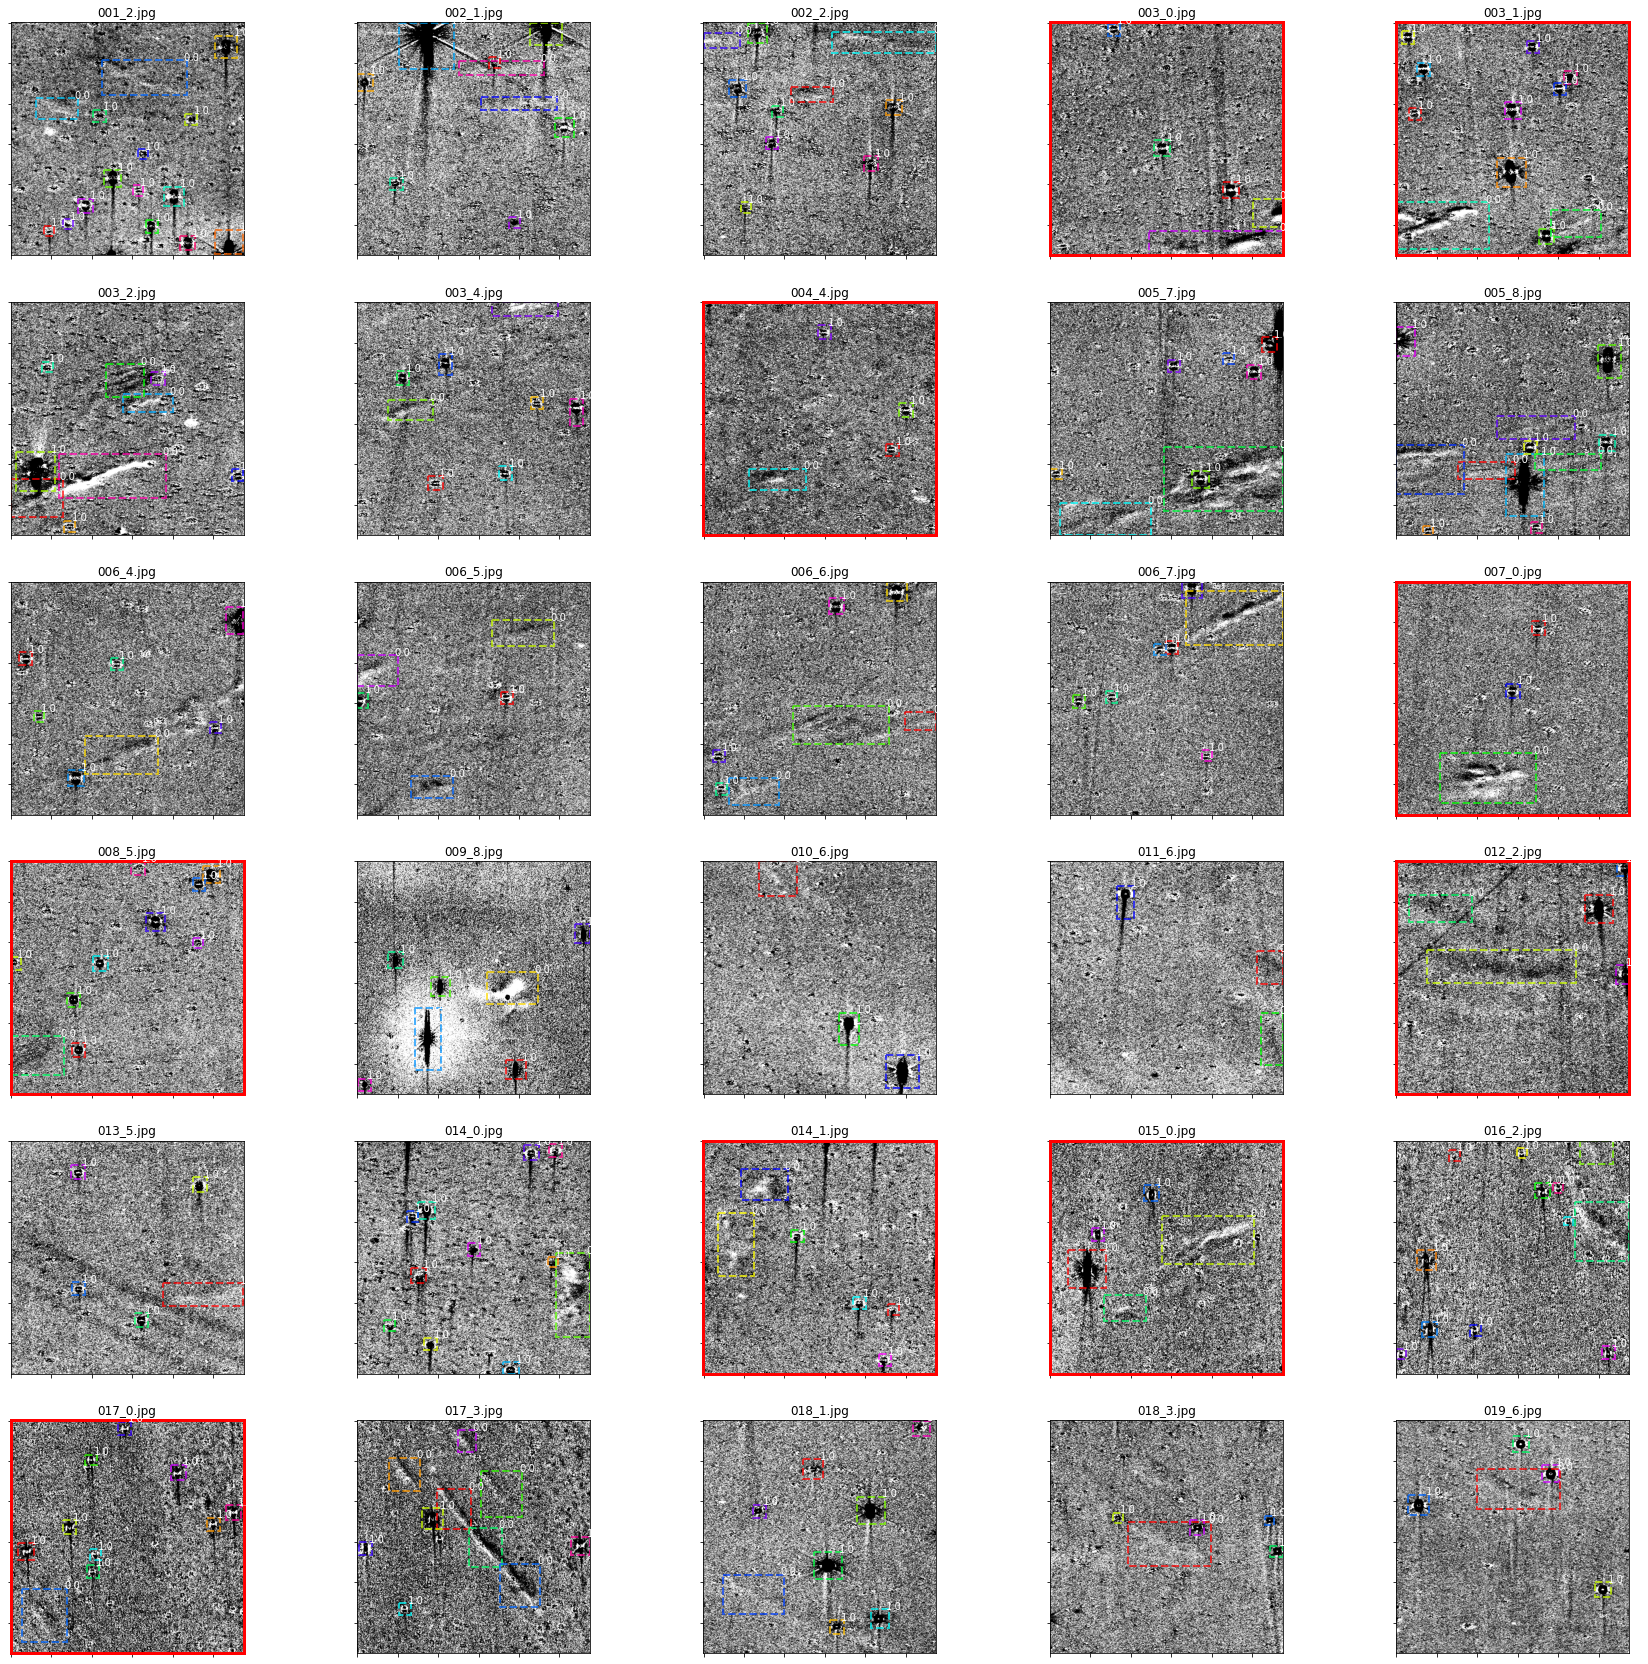

In [99]:
 # plot train and test

fig, axs = plt.subplots(ncols=5,  nrows=6, figsize=(30, 30))

axs = axs.flatten()

imgfiles.sort()
for i, imgfile in enumerate(imgfiles):
    #imgfile = imgfiles[0]
    fitspath = imgfile.replace('jpg', 'fits.npz')
    fitsarr = np.load(fitspath)['fitsarr']
    
    if len(fitsarr.shape)!=3:
        # expand dimensions
        fitsarr = np.repeat( np.expand_dims(fitsarr, axis=2), repeats=3, axis=2 )

    bboxes_clsid = anndic[imgfile]
    bboxes = bboxes_clsid[:, :4]
    clsids = bboxes_clsid[:, 4] 

    print(imgfile, clsids)
    rgbimg = fits_to_uint8(fitsarr, vmin=-1, vmax=1)
    title = imgfile.split('/')[-1]
    ax = axs[i]
    plot_bboxes(ax=ax, img=rgbimg, bboxes=bboxes, title=title, labels=clsids)
    #ax.set_axis_off()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if imgfile in imgfiles_test:
        [sp.set_color('r') for sp in ax.spines.values()]
        [sp.set_linewidth(3) for sp in ax.spines.values()]
    

fig.savefig('./dataset/LE_cand1_largebox/tiles/ann.pdf', dpi=100)
    


In [100]:
# write annot information to txt file

titles =  [ '', '_r90', '_r180', '_r270',
             '_fliph', '_fliph_r90', '_fliph_r180', '_fliph_r270',]
             #'_flipv', '_flipv_r90', '_flipv_r180', '_flipv_r270',]

imgfiles_ = [ s.replace('tiles/', 'tiles_aug/') for s in imgfiles]


with open("./dataset/LE_cand1_largebox/train_aug.txt", 'w') as f:
    
    for idx in idx_train:
        imgfile = imgfiles_[idx]
        # get augmentated tiles
        augpaths = [imgfile.replace('.jpg', t)+'.jpg' for t in titles ]
        for image_ann in augpaths:
            print(image_ann)
            bboxes = anndic_aug[ image_ann ]
            
            # write boxes to txt file
            for i in range( len(bboxes)):
                x1, y1, x2, y2 = bboxes[i][:4]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                xmin = str(x1)
                ymin = str(y1)
                xmax = str(x2)
                ymax = str(y2)
                class_ind = str( int( bboxes[i][4] ) )
                image_ann += ' ' + ','.join([xmin, ymin, xmax, ymax, class_ind])
            f.write(image_ann + "\n")
              
            
with open("./dataset/LE_cand1_largebox/test_aug.txt", 'w') as f:
    
    for idx in idx_test:
        imgfile = imgfiles_[idx]
        # get augmentated tiles
        augpaths = [imgfile.replace('.jpg', t)+'.jpg' for t in titles ]
        for image_ann in augpaths:
            print(image_ann)
            bboxes = anndic_aug[ image_ann ]
            
            # write boxes to txt file
            for i in range( len(bboxes)):
                x1, y1, x2, y2 = bboxes[i][:4]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                xmin = str(x1)
                ymin = str(y1)
                xmax = str(x2)
                ymax = str(y2)
                class_ind = str( int( bboxes[i][4] ) )
                image_ann += ' ' + ','.join([xmin, ymin, xmax, ymax, class_ind])
            f.write(image_ann + "\n")


./dataset/LE_cand1_largebox/tiles_aug/002_2.jpg
./dataset/LE_cand1_largebox/tiles_aug/002_2_r90.jpg
./dataset/LE_cand1_largebox/tiles_aug/002_2_r180.jpg
./dataset/LE_cand1_largebox/tiles_aug/002_2_r270.jpg
./dataset/LE_cand1_largebox/tiles_aug/002_2_fliph.jpg
./dataset/LE_cand1_largebox/tiles_aug/002_2_fliph_r90.jpg
./dataset/LE_cand1_largebox/tiles_aug/002_2_fliph_r180.jpg
./dataset/LE_cand1_largebox/tiles_aug/002_2_fliph_r270.jpg
./dataset/LE_cand1_largebox/tiles_aug/010_6.jpg
./dataset/LE_cand1_largebox/tiles_aug/010_6_r90.jpg
./dataset/LE_cand1_largebox/tiles_aug/010_6_r180.jpg
./dataset/LE_cand1_largebox/tiles_aug/010_6_r270.jpg
./dataset/LE_cand1_largebox/tiles_aug/010_6_fliph.jpg
./dataset/LE_cand1_largebox/tiles_aug/010_6_fliph_r90.jpg
./dataset/LE_cand1_largebox/tiles_aug/010_6_fliph_r180.jpg
./dataset/LE_cand1_largebox/tiles_aug/010_6_fliph_r270.jpg
./dataset/LE_cand1_largebox/tiles_aug/002_1.jpg
./dataset/LE_cand1_largebox/tiles_aug/002_1_r90.jpg
./dataset/LE_cand1_largebox/

### make a shuffled dataset

In [221]:
annot_path = "./dataset/LE_cand1/train_aug.txt"
with open(annot_path, 'r') as f:
    txt = f.readlines()
    annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]


In [222]:
# shuffle
np.random.seed(seed=2)
idxs = np.random.permutation( len(annotations) )

with open(annot_path, 'w') as f:
    
    for idx in idxs:
        ann = annotations[idx] + '\n'
        f.write(ann)
        

In [48]:
idxs

array([ 42,  23,  45,  48,  13,   3,   6, 150,  66,  64,   2, 138, 146,
       145, 106,  12,  41, 135,  87,   5,  25,  78, 141, 118,  24,  65,
        54, 108, 158, 159, 112,  29,  97,  35, 162,  79,  91,  44, 136,
       149,  14, 155, 115,  93, 153, 147,  71,  94, 140, 142, 161, 151,
       133, 139,  11, 114,  28,  53,  77,   0,  27, 144,  36, 130, 143,
        99,  20, 131, 129, 126,  30, 128, 123,  59, 152, 113,  89,  92,
        85,  21,  55,  16, 166,  74, 134, 111, 122,  84,  18,  98,  61,
        81, 137,  68,   1,  82,  56,  19, 100,  86,  70, 101,   9,  60,
        34,  40,  10,  76, 125,  26,  32, 164,  96,  83,  62,  90, 110,
       127,  57,  73, 117, 120, 165,  17, 119,   8, 109, 105, 167,  39,
        49, 157, 132,  50,  52,  80, 156, 121, 160,  46,  88,  69,  67,
       154,  58,  33,  38, 103,  51, 107,   4, 102,  37, 116, 124, 148,
        31,  63,  47, 163,  95,   7, 104,  75,  43,  22,  72,  15])

In [80]:
idxs.shape

(108,)